In [1]:
import sys
import os


if sys.platform == 'darwin':
    print('Using Mac locally')
    base_dir = os.getcwd()
    data_dir = './data'
    
elif sys.platform == 'linux' and os.getcwd() == '/content':
    print('Using colab')
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    root_dir = "/content/gdrive/My Drive/"
    base_dir = root_dir
    data_dir = './data'
    %cd /content/gdrive/MyDrive/fsdl-2022-project/codebase/EmotionGAN/notebook
else:
    raise "System platform is not recognized."

Using colab
Mounted at /content/gdrive
/content/gdrive/MyDrive/fsdl-2022-project/codebase/EmotionGAN/notebook


In [2]:
import sys
sys.path.append("..")

import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import cv2

from utils.notebook_utils import GANmut

Device: cpu


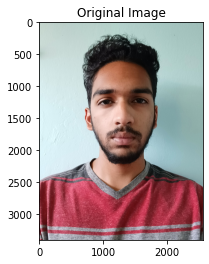

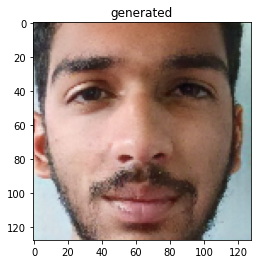

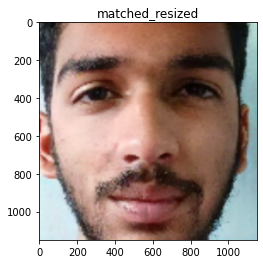

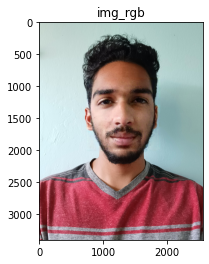

In [3]:
G = GANmut(G_path='../learned_generators/lin_2d/1000000-G.ckpt',model='linear')
angle=np.pi
strength=0.3
G.emotion_edit(img_path='../Images/taran.jpg', theta=0, rho = 0.4, save = False )


Device: cpu


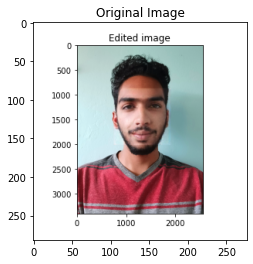

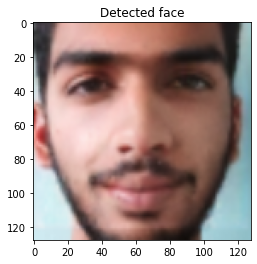

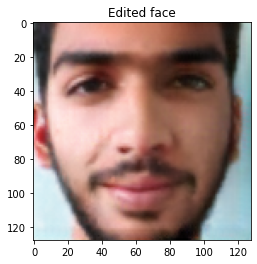

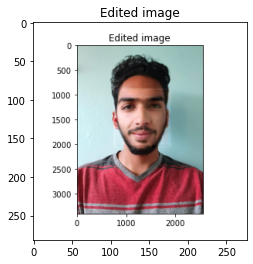

In [4]:
G = GANmut(G_path='../learned_generators/lin_2d/1000000-G.ckpt',model='linear')
angle=np.pi
strength=0.3
G.emotion_edit_original(img_path='../Images/fake-taran.png', theta=0, rho = 0.4, save = False )


Device: cpu


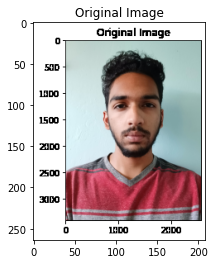

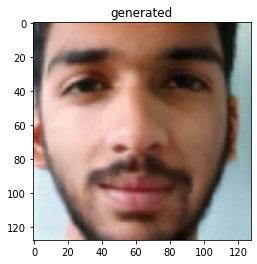

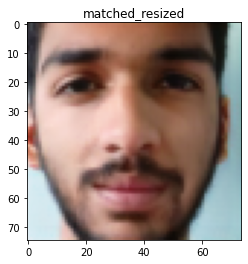

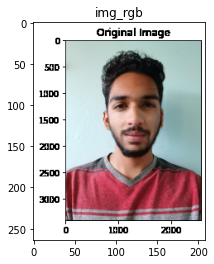

In [6]:
G = GANmut(G_path='../learned_generators/lin_2d/1000000-G.ckpt',model='linear')
angle=np.pi
strength=0.3
G.emotion_edit(img_path='../Images/original-taran.png', theta=0, rho = 0.4, save = False )


In [5]:
src = cv2.imread('../Images/edited-taran-face.png')
ref = cv2.imread('../Images/original-taran-face.png')
multi = True if src.shape[-1] > 1 else False
matched = exposure.match_histograms(src, ref, multichannel=multi)

In [6]:
src.shape

(264, 257, 3)

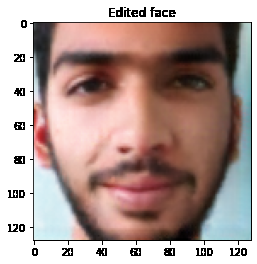

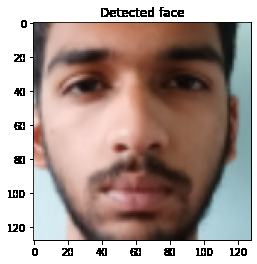

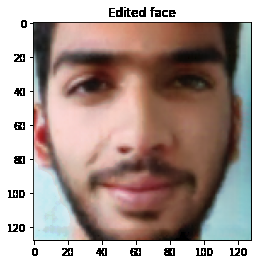

In [7]:
from google.colab.patches import cv2_imshow

cv2_imshow(src)
cv2_imshow(ref)
cv2_imshow(matched)
# cv2.waitKey(0)

## Study the code

In [86]:
import os
from pathlib import Path
import sys

import dlib
import matplotlib.pyplot as plt
import torch
import cv2
from skimage import exposure, img_as_float, img_as_ubyte
from skimage.transform import rescale, resize, downscale_local_mean,rotate
from imutils.face_utils import rect_to_bb
import numpy as np

sys.path.append("../")
from models.model_linear_2d import Generator as Generator_l2
from models.model_gaussian_2d import Generator as Generator_g2


class GANmut2:
    def __init__(self, G_path, model="linear", g_conv_dim=64, c_dim=7, g_repeat_num=6):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Device:", self.device)
        self.model = model

        if self.model == "linear":
            self.G = Generator_l2(self.device, g_conv_dim, c_dim, g_repeat_num)

        elif self.model == "gaussian":
            self.G = Generator_g2(self.device, g_conv_dim, c_dim, g_repeat_num)

        else:
            raise ValueError("choose either model='linear' or model='gaussian'")

        self.G.load_state_dict(
            torch.load(G_path, map_location=lambda storage, loc: storage)
        )
        self.G.to(self.device)
        self.detector = dlib.get_frontal_face_detector()

    def emotion_edit(self, img_path, x=None, y=None, theta=None, rho=None, save=False):

        if self.model == "linear":
            assert (rho is not None) or (
                theta is not None
            ), "if model is linear you must provide rho and theta"
        else:
            assert (x is not None) and (
                y is not None
            ), "if model is gaussian you must provide x and y"

        img = cv2.imread(img_path, 1)  # BGR
        img_rgb = img[:, :, [2, 1, 0]]
        plt.title('Original Image')
        plt.imshow(img_rgb)

        # extract face
        det = self.detector(img, 1)[0]
        (xx, yy, w, h) = rect_to_bb(det)
        face = cv2.resize(img[yy : yy + h, xx : xx + w], (128, 128))

        # save this format for histogram matching
        face_hwc = face[:,:,[2,1,0]]

        # adapt image format for G
        face = face.transpose((2, 0, 1))  # [H,W,C] --> [C,H,W]
        face = (face / 255.0 - 0.5) / 0.5  # normalize to [-1, 1]
        face = torch.from_numpy(face).float().unsqueeze(0).to(self.device)

        # edit emotion

        with torch.no_grad():

            if self.model == "linear":
                mode = "manual_selection"
                expr = (
                    (torch.tensor([np.cos(theta), np.sin(theta)]) * rho)
                    .to(self.device)
                    .float()
                )
                face_g = (
                    self.G(face, None, None, mode=mode, manual_expr=expr)[0][
                        0, [2, 1, 0], :, :
                    ]
                    / 2
                    + 0.5
                )
            else:
                expr = torch.Tensor([x, y]).unsqueeze(0).to(self.device)
                face_g = self.G(face, expr)[0][0, [2, 1, 0], :, :] / 2 + 0.5

        face_g = face_g.transpose(0, 2).transpose(0, 1).detach().cpu().numpy()
        plt.figure()
        plt.title("generated")
        plt.imshow(face_g)

        # histogram matching
        face_g_sk = img_as_float(face_g)
        img_rgb_sk = img_as_float(face_hwc)
        multi = True if face_g.shape[-1] > 1 else False
        matched = exposure.match_histograms(face_g_sk, img_rgb_sk, multichannel=multi)
        matched_resized = resize(matched, (h, w))
        plt.figure()
        plt.title("matched_resized")
        plt.imshow(matched_resized)

        img_rgb[yy : yy + h, xx : xx + w] = matched_resized *255
        plt.figure()
        plt.title("img_rgb")
        plt.imshow(img_rgb)

        if save:
            save_dir = "../edited_images"
            if self.model == "linear":
                save_dir = "../edited_images_linear"
            Path(save_dir).mkdir(parents=True, exist_ok=True)
            if self.model == "linear":
                img_name = (
                    "theta_{:0.2f}_rho_{:0.2f}".format(theta, rho)
                    + os.path.split(img_path)[-1]
                )
            else:
                img_name = (
                    "x_{:0.2f}_y_{:0.2f}".format(x, y) + os.path.split(img_path)[-1]
                )

            img_name = os.path.join(save_dir, img_name)
            plt.imsave(img_name, img_rgb)
            print(f"edited image saved in {img_name}")
        

Device: cpu


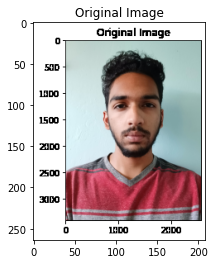

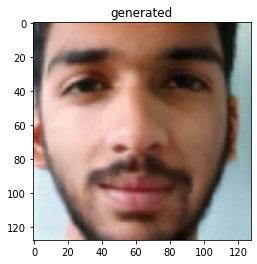

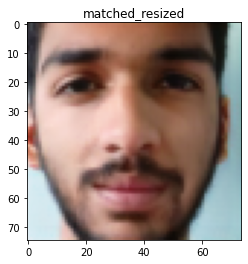

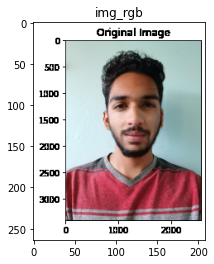

In [87]:
G = GANmut2(G_path='../learned_generators/lin_2d/1000000-G.ckpt',model='linear')
angle=np.pi
strength=0.3
G.emotion_edit(img_path='../Images/original-taran.png', theta=0, rho = 0.4, save = False )